# Neural Network

neural network system

Report required performance measures

• F1-score 
• Accuracy

## Import necessary library

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

In [200]:
def getData(fname1, fname2):
    df_train = pd.read_csv(fname1)
    df_test = pd.read_csv(fname2)
    data_train = np.array(df_train)
    data_test = np.array(df_test)
    xdata_train = data_train[:,:len(data_train[0]) - 1]
    ydata_train = data_train[:, -1]
    xdata_test = data_test[:,:len(data_test[0]) - 1]
    ydata_test = data_test[:, -1]
    
    return xdata_train, ydata_train, xdata_test, ydata_test
    
xdata_train_select, ydata_train_select, xdata_test_select, ydata_test_select = getData("mushroom_train_select.csv", "mushroom_test_select.csv")

print(f"The shape of training xdata shape is", xdata_train_select.shape)
print(f"The shape of training ydata shape is", ydata_train_select.shape)
print(f"The shape of testing xdata shape is", xdata_test_select.shape)
print(f"The shape of testing ydata shape is", ydata_test_select.shape)

The shape of training xdata shape is (42748, 32)
The shape of training ydata shape is (42748,)
The shape of testing xdata shape is (18321, 32)
The shape of testing ydata shape is (18321,)


In [205]:
class Model(nn.Module):
    def __init__(self, input_features): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(input_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x): # Define forward pass in the forward method 
#         x = x.view(x.shape[0], -1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x 

In [220]:
def train_validate_model(xdata_train_select, ydata_train_select, lr = 0.01, reg_val = 1e-4, batch_size = 32): 
    # Copy in case of overwrite
    xdata_train = np.copy(xdata_train_select)
    ydata_train = np.copy(ydata_train_select)
    
    # Split data
    xdata_train, xdata_val, ydata_train, ydata_val = train_test_split(xdata_train, ydata_train, test_size=0.2, random_state=42)
    
    # Normalize dataset
    # Create scaler object and fit to data
    scaler = StandardScaler()
    scaler.fit(xdata_train)
    
    # Apply scaler to data
    xdata_train = scaler.transform(xdata_train)
    xdata_val = scaler.transform(xdata_val)
    
    training_loss_history = []
    val_loss_history = []
    training_acc_history = []
    val_acc_history = []
    f1_score_history = []
    
    # Convert your data to PyTorch tensors
    xdata_train = torch.Tensor(xdata_train)  # Shape: (num_samples, num_features)
    ydata_train = torch.Tensor(ydata_train)  # Shape: (num_samples,)
    xdata_val = torch.Tensor(xdata_val)  # Shape: (num_samples, num_features)
    ydata_val = torch.Tensor(ydata_val)  # Shape: (num_samples,)
    
    # Create a PyTorch TensorDataset object
    trainset = TensorDataset(xdata_train, ydata_train)
    valset = TensorDataset(xdata_val, ydata_val)
    
    # Create a PyTorch DataLoader object
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    model = Model(32)
    epoch_nums = 30
    
    device = torch.device("cpu")
    model.to(device) # Move model to device
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epoch_nums):
        
        # Training the model
        model.train() # set model to training mode
        running_loss = 0
        running_acc = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            
            output = model(inputs) # Forward pass
            loss = criterion(output, labels.long()) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            running_acc += torch.sum(predictions == labels).item() 
#         print(f"Training loss = {running_loss / len(trainset)}, accuracy = {running_acc / len(trainset) }")
        training_loss_history.append(running_loss / len(trainset))
        training_acc_history.append(running_acc / len(trainset))
        
        # Eval the model on validation
        model.eval()
        running_loss = 0
        running_acc = 0
        score = 0
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) # Move batch to device
#                 optimizer.zero_grad()

                output = model(inputs) # Forward pass
                loss = criterion(output, labels.long()) # Compute loss
                running_loss += loss.item()
                predictions = torch.argmax(output, dim=1)
                running_acc += torch.sum(predictions == labels).item() 
                score += f1_score(predictions, labels)
#         print(f"Validation loss = {running_loss / len(valset)}, accuracy = {running_acc / len(valset) }")
        val_loss_history.append(running_loss / len(valset))
        val_acc_history.append(running_acc / len(valset))
        f1_score_history.append(score / len(valloader))
        
    print(f"The mean of training loss = {np.mean(training_loss_history)}, std = {np.std(training_loss_history)}")
    print(f"The mean of validation loss = {np.mean(val_loss_history)}, std = {np.std(val_loss_history)}")
    print(f"The mean of training accuracy = {np.mean(training_acc_history)}, std = {np.std(training_acc_history)}")
    print(f"The mean of validation accuracy = {np.mean(val_acc_history)}, std = {np.std(val_acc_history)}")
    print(f"The mean of f1_score = {np.mean(f1_score_history)}, std = {np.std(f1_score_history)}")
    
    # Plot the learning curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(np.arange(len(training_loss_history)), training_loss_history, label = "Training Loss")
    ax1.plot(np.arange(len(val_loss_history)), val_loss_history, label = "Validation Loss")
    ax1.legend()

    ax2.plot(np.arange(len(training_acc_history)), training_acc_history, label = "Training Accuracy")
    ax2.plot(np.arange(len(val_acc_history)), val_acc_history, label = "Validation Accuracy")
    ax2.legend()
    

## Experiment to find the best batch size
Parameter setting : lr = 0.01, reg_val = 1e-3, batch_size = 16

The mean of training loss = 0.02806407604771409, std = 0.005419674325229932
The mean of validation loss = 0.02818495693959688, std = 0.004958805406917511
The mean of training accuracy = 0.8750521472990622, std = 0.09991276962751165
The mean of validation accuracy = 0.8757115009746589, std = 0.08266862883154323
The mean of f1_score = 0.8867927710321727, std = 0.06967886831726633


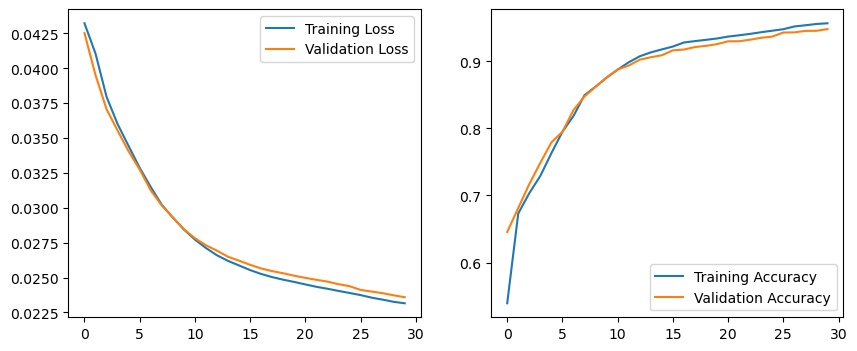

In [221]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.01, reg_val = 1e-3, batch_size = 16)

Parameter setting : lr = 0.01, reg_val = 1e-3, batch_size = 32

The mean of training loss = 0.015931480860369458, std = 0.002050862596269529
The mean of validation loss = 0.016069252384452563, std = 0.0018896076273431904
The mean of training accuracy = 0.8104479794140009, std = 0.07929587844170442
The mean of validation accuracy = 0.8101598440545809, std = 0.06849869294670174
The mean of f1_score = 0.830374383938514, std = 0.05719182195475713


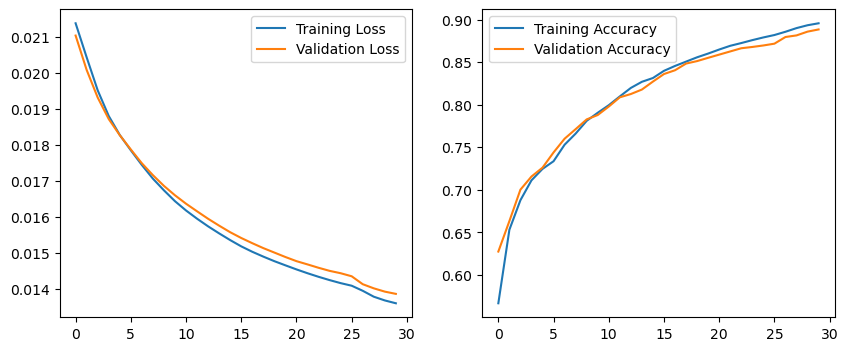

In [208]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.01, reg_val = 1e-3, batch_size = 32)

Parameter setting : lr = 0.01, reg_val = 1e-3, batch_size = 64

The mean of training loss = 0.008804726006628131, std = 0.0010457066640599
The mean of validation loss = 0.00885196719636694, std = 0.0009841559074110435
The mean of training accuracy = 0.7507953681501841, std = 0.08923572772817882
The mean of validation accuracy = 0.751317738791423, std = 0.08302977539882886
The mean of f1_score = 0.7699016943966448, std = 0.12676946661504343


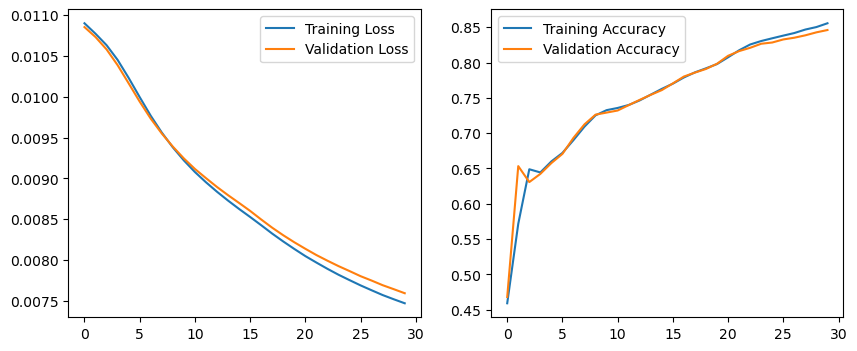

In [209]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.01, reg_val = 1e-3, batch_size = 64)

## Experiment to find the best learning rate
Using the best performance batch size = 16

Parameter setting : lr = 0.001, reg_val = 1e-3, batch_size = 16

The mean of training loss = 0.040225672157909446, std = 0.0019115341637570985
The mean of validation loss = 0.040384307952652194, std = 0.001827021920769275
The mean of training accuracy = 0.657113476421623, std = 0.04808617528940006
The mean of validation accuracy = 0.6537465886939571, std = 0.04863427110036571
The mean of f1_score = 0.7163676567613724, std = 0.01054172798961895


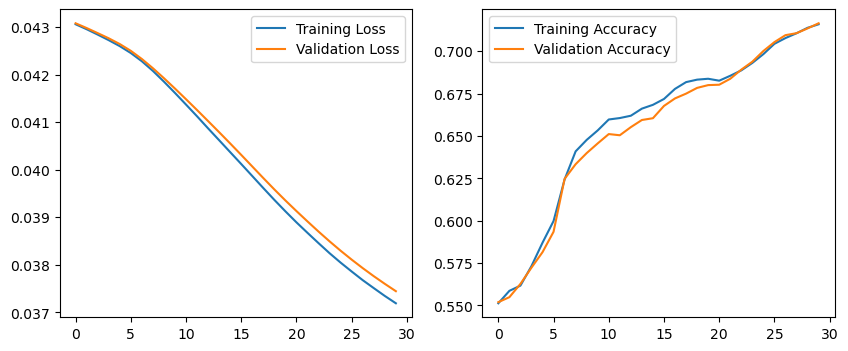

In [210]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.001, reg_val = 1e-3, batch_size = 16)

Parameter setting : lr = 0.1, reg_val = 1e-3, batch_size = 16

The mean of training loss = 0.024054208303747195, std = 0.002287677135720185
The mean of validation loss = 0.02441616344370573, std = 0.0014862699659457892
The mean of training accuracy = 0.9358451761311577, std = 0.03964709215190119
The mean of validation accuracy = 0.9300272904483431, std = 0.024647633526438537
The mean of f1_score = 0.9338656536743228, std = 0.02355154985902897


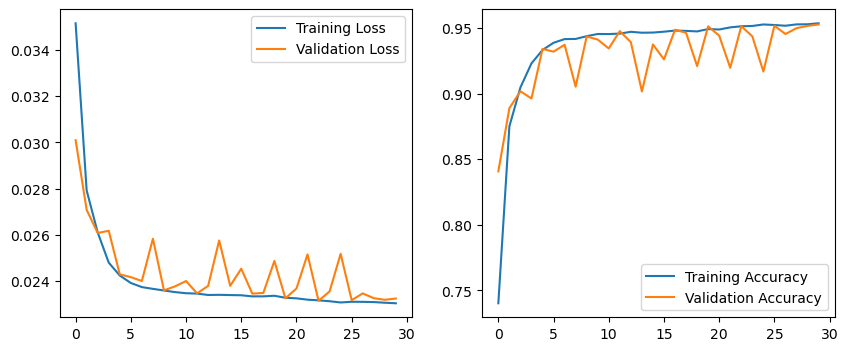

In [211]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.1, reg_val = 1e-3, batch_size = 16)

## Experiment to find the best coefficient
Using the best performance batch size = 16, lr = 0.1
Parameter setting : lr = 0.1, reg_val = 1e-4, batch_size = 16

The mean of training loss = 0.025237053631138522, std = 0.00198371750628052
The mean of validation loss = 0.025535486472628967, std = 0.0010341412458917713
The mean of training accuracy = 0.9107871805368735, std = 0.03259039264385906
The mean of validation accuracy = 0.9066939571150099, std = 0.015304118768574543
The mean of f1_score = 0.9079169272051765, std = 0.014595463859467915


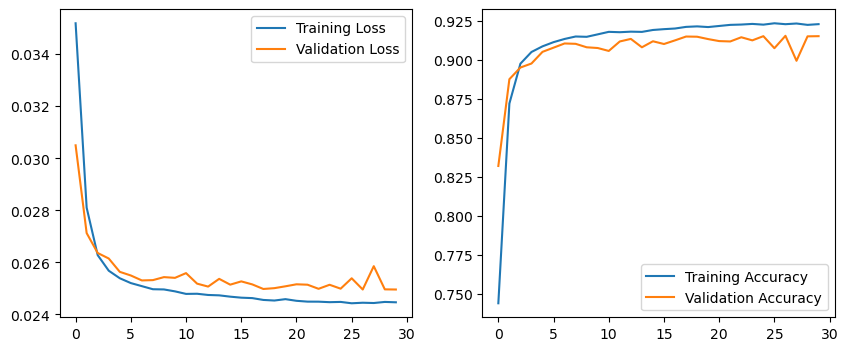

In [212]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.1, reg_val = 1e-4, batch_size = 16)

The mean of training loss = 0.02307879770789404, std = 0.0025948332765113407
The mean of validation loss = 0.023012959576257253, std = 0.001716036511888241
The mean of training accuracy = 0.9440308400101372, std = 0.04386727621096593
The mean of validation accuracy = 0.9458713450292398, std = 0.026582000266429335
The mean of f1_score = 0.949060551416899, std = 0.02506985855125152


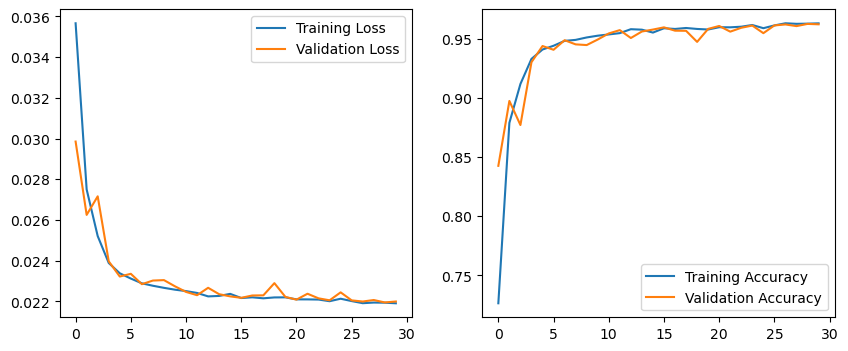

In [213]:
train_validate_model(xdata_train_select, ydata_train_select, lr = 0.1, reg_val = 1e-5, batch_size = 16)

## Test
According to the experiments above, the best parameter setting is lr = 0.1, reg_val = 1e-5, batch_size = 16

In [216]:
def test_model(xdata_train_select, ydata_train_select, xdata_test_select, ydata_test_select, lr = 0.1, reg_val = 1e-5, batch_size = 16):
    # Copy in case of overwrite
    xdata_train = np.copy(xdata_train_select)
    ydata_train = np.copy(ydata_train_select)
    xdata_test = np.copy(xdata_test_select)
    ydata_test = np.copy(ydata_test_select)
    
    # Normalize dataset
    # Create scaler object and fit to data
    scaler = StandardScaler()
    scaler.fit(xdata_train)
    
    # Apply scaler to data
    xdata_train = scaler.transform(xdata_train)
    xdata_test = scaler.transform(xdata_test)
    
    
    # Convert your data to PyTorch tensors
    xdata_train = torch.Tensor(xdata_train)  # Shape: (num_samples, num_features)
    ydata_train = torch.Tensor(ydata_train)  # Shape: (num_samples,)
    xdata_test = torch.Tensor(xdata_test)  # Shape: (num_samples, num_features)
    ydata_test = torch.Tensor(ydata_test)  # Shape: (num_samples,)
    
    # Create a PyTorch TensorDataset object
    trainset = TensorDataset(xdata_train, ydata_train)
    testset = TensorDataset(xdata_test, ydata_test)
    
    # Create a PyTorch DataLoader object
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    model = Model(32)
    epoch_nums = 30
    
    device = torch.device("cpu")
    model.to(device) # Move model to device
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epoch_nums):
        
        # Training the model
        model.train() # set model to training mode
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            
            output = model(inputs) # Forward pass
            loss = criterion(output, labels.long()) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
        
    # Eval the model on validation
    model.eval()
    running_acc = 0
    score = 0
    list_target = []
    list_pred = []
    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # Move batch to device
            list_target.extend(labels)
            output = model(inputs) # Forward pass
            predictions = torch.argmax(output, dim=1)
            list_pred.extend(predictions)
            running_acc += torch.sum(predictions == labels).item() 
            score += f1_score(predictions, labels)
        
    print(f"Testing accuracy = {running_acc / len(testset)}")
    print(f"The f1_score = {score / len(testloader)}")
    
    # Plot the confusion matrix
    conf_matrix = confusion_matrix(list_target, list_pred)
    plt.figure(figsize = (6, 6))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
    plt.title("Confusion Matrix for ANN System")


Testing accuracy = 0.9372850826919928
The f1_score = 0.9410237582397579


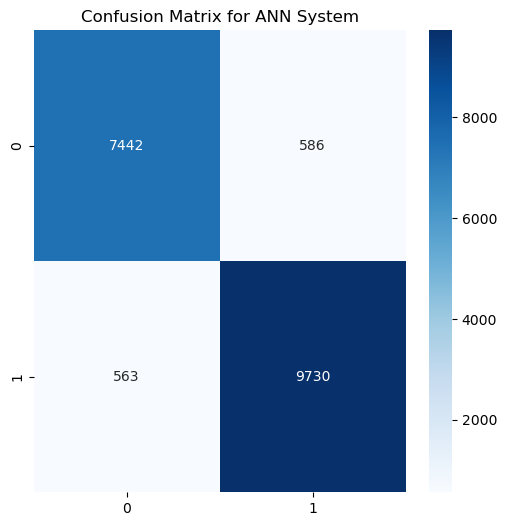

In [217]:
test_model(xdata_train_select, ydata_train_select, xdata_test_select, ydata_test_select, lr = 0.1, reg_val = 1e-5, batch_size = 16)